# ODSI-DB Exploratory Data Analysis (EDA)

215 images overall

Annotaions Histogram (sorted):

[('Enamel', 2286), ('Marginalgingiva', 859), ('Attachedgingiva', 328), ('Metal', 311), ('Skin', 310), ('Oralmucosa', 306), ('Plastic', 276), ('Outoffocusarea', 225), ('Lip', 217), ('Stain', 217), ('Shadow/Noise', 177), ('Gingivitis', 166), ('Calculus', 148), ('Attrition/Erosion', 133), ('Initialcaries', 85), ('Hair', 80), ('Prosthetics', 76), ('Hardpalate', 63), ('Softpalate', 60), ('Tongue', 58), ('Root', 58), ('Microfracture', 40), ('Bloodvessel', 34), ('Dentinecaries', 30), ('Plaque', 21), ('Inflammation', 20), ('Fluorosis', 19), ('Ulcer', 16), ('Mole', 14), ('Pigmentation', 14), ('Leukoplakia', 8), ('Makeup', 4), ('Fibroma', 0), ('Malignantlesion', 0)]


10 Annotaions in Whitelist (freq>200):

['Enamel', 'Marginalgingiva', 'Attachedgingiva', 'Metal', 'Skin', 'Oralmucosa', 'Plastic', 'Outoffocusarea', 'Lip', 'Stain']


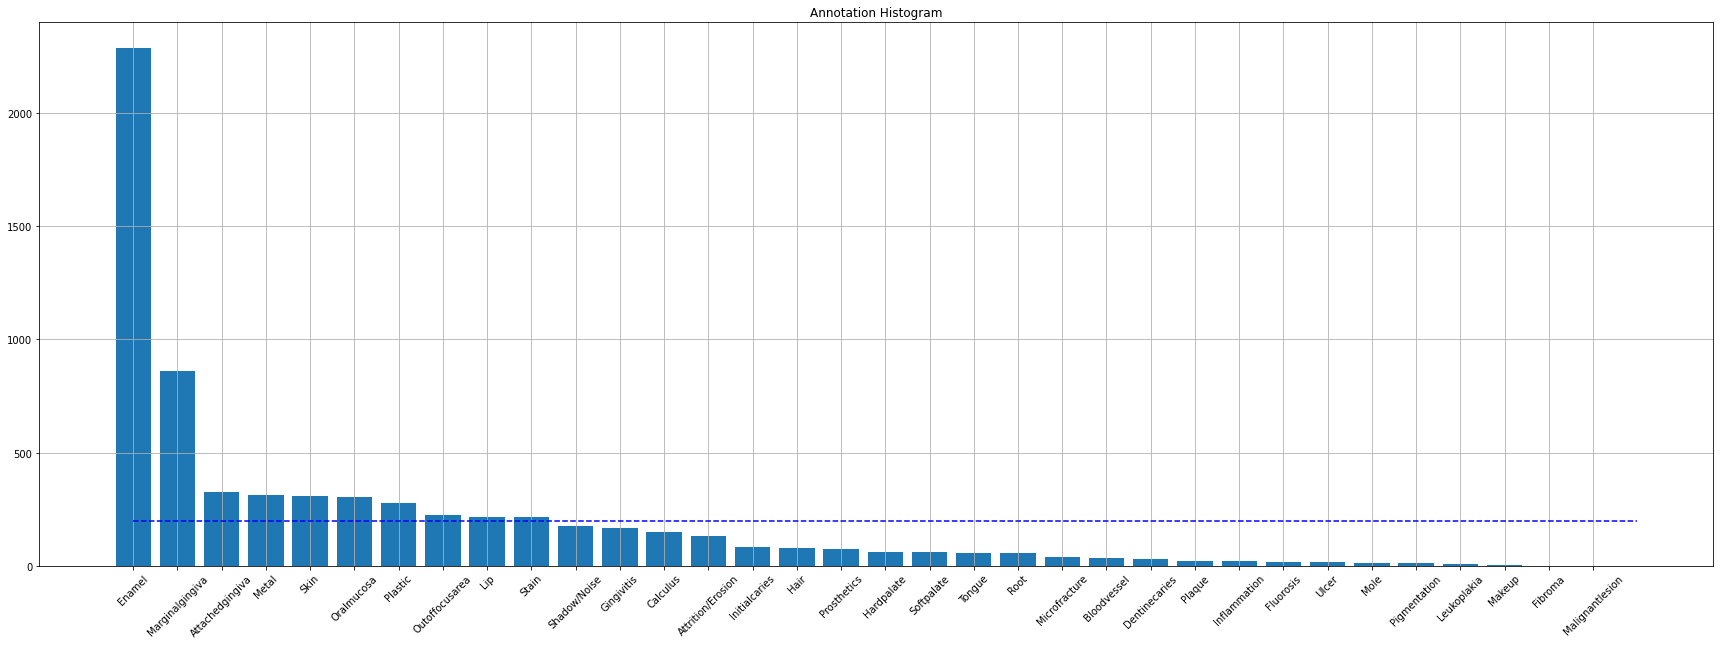

Test-Case: 04123fb5_front_inpainted_GDBICP_similarity

masks -->  odsi_db/dataset/04123fb5_front_inpainted_GDBICP_similarity_masks.tif
annot -->  odsi_db/dataset/04123fb5_front_inpainted_GDBICP_similarity_annot.csv
tiff -->  odsi_db/dataset/04123fb5_front_inpainted_GDBICP_similarity.tif

34 Annotations, exluding Specular-Reflections:
['Oralmucosa', 'Oralmucosa', 'Oralmucosa', 'Oralmucosa', 'Attachedgingiva', 'Attachedgingiva', 'Attachedgingiva', 'Attachedgingiva', 'Gingivitis', 'Gingivitis', 'Gingivitis', 'Gingivitis', 'Gingivitis', 'Gingivitis', 'Plaque', 'Plaque', 'Marginalgingiva', 'Marginalgingiva', 'Marginalgingiva', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Enamel', 'Calculus', 'Calculus']


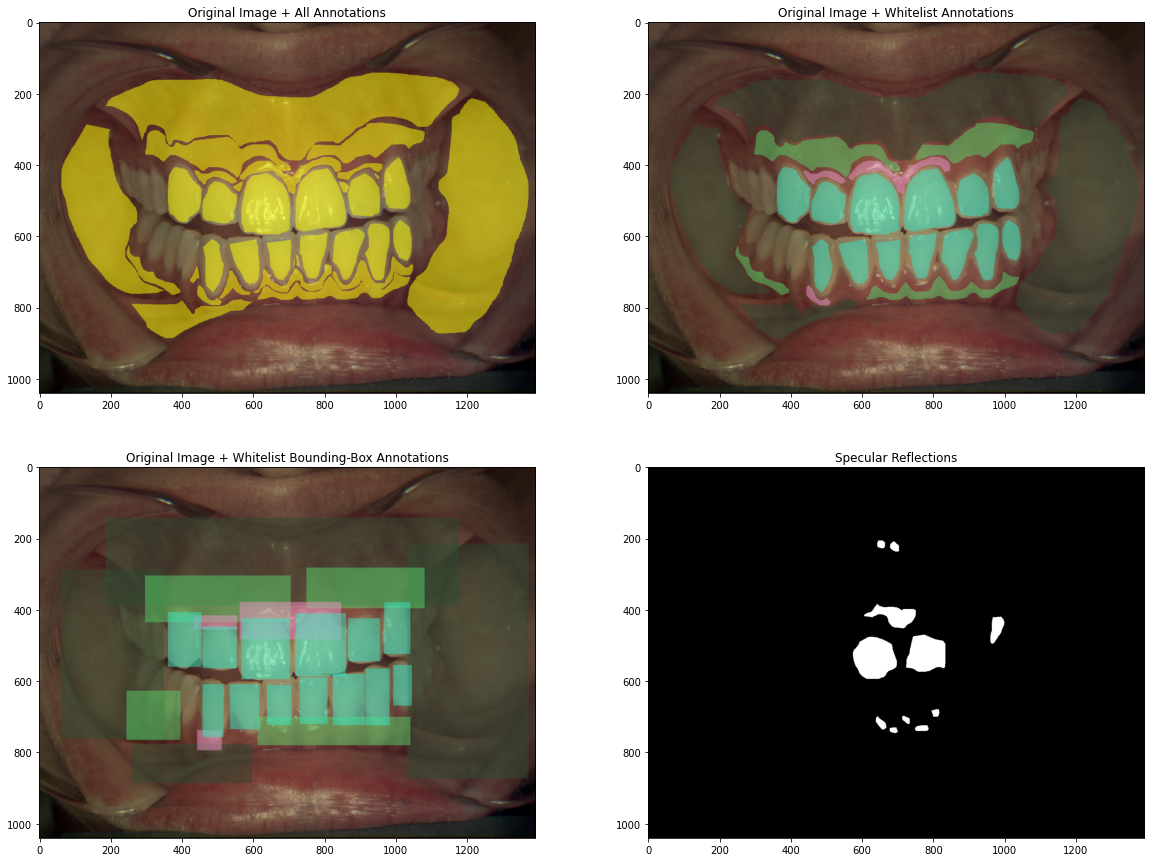

In [1]:
import numpy as np
from random import randint
from os import path, listdir
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon
from cv2 import imread, cvtColor, COLOR_BGR2RGB, fillPoly, addWeighted

anotations_min_freq = 200
basepath = 'odsi_db/dataset'

# ----------------------------------------------------------------------------------------------------

def write_xml_annotation(img_folder, img_file, img_size, obj_name, boundbox, xml_filename):

    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = img_folder   # Folder that contains the images
    ET.SubElement(annotation, "filename").text = img_file   # Name of the physical file that exists in the folder
    ET.SubElement(annotation, "path").text = path.join('./'+img_folder, img_file)
    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, "database").text = "ODSI-DB"      # Database name
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(img_size[0])    # Image width
    ET.SubElement(size, "height").text = str(img_size[1])   # Image height
    ET.SubElement(size, "depth").text = str(img_size[2])    # Image depth (1 for black/white, 3 for color)
    ET.SubElement(annotation, "segmented").text = "0"       # 
    obj = ET.SubElement(annotation, "object")
    ET.SubElement(obj, "name").text = obj_name              # Object name
    ET.SubElement(obj, "pose").text = "Unspecified"         # Object pose
    ET.SubElement(obj, "truncated").text = "0"              # '1' if the object is partially visible in the bounding box
    ET.SubElement(obj, "difficult").text = "0"              # '1' if the object is difficult to recognize
    bndbox = ET.SubElement(obj, "bndbox")
    ET.SubElement(bndbox, "xmin").text = str(boundbox[0])   # Bounding box top-left x coordinate
    ET.SubElement(bndbox, "ymin").text = str(boundbox[1])   # Bounding box top-left y coordinate
    ET.SubElement(bndbox, "xmax").text = str(boundbox[2])   # Bounding box bottom-right x coordinate
    ET.SubElement(bndbox, "ymax").text = str(boundbox[3])   # Bounding box bottom-right y coordinate
    tree = ET.ElementTree(annotation)
    tree.write(xml_filename)

# ----------------------------------------------------------------------------------------------------
    
files = {'masks': None, 'annot': None, 'tiff': None}

annotations_hist = {}

files_cnt = 0
filename_template = None
for filename in sorted(listdir(basepath)):
    
    if filename.startswith('invalid_'):
        continue
    
    file = path.join(basepath, filename)
    
    if not filename_template:
        filename_template = path.splitext(filename)[0].replace('_masks', '').replace('_annot', '')
    
    if filename.startswith(filename_template):
        if filename.endswith('_masks.tif'):
            files['masks'] = file
        elif filename.endswith('_annot.csv'):
            files['annot'] = file
        else:
            files['tiff'] = file
    
    if filename.endswith('_annot.csv'):
        with open(path.join(basepath, filename)) as f:
            lis = [line.split(',') for line in f]
            for x in lis:
                class_name = x[0].split(';')[0].replace(' ','')
                if class_name != 'Specularreflection':
                    if class_name in annotations_hist:
                        annotations_hist[class_name] += 1
                    else:
                        annotations_hist[class_name] = 0
        files_cnt += 1
                    
annotations_hist_sorted = sorted(annotations_hist.items(), key=lambda x: x[1], reverse=True)

img_tiff = cvtColor(imread(files['tiff']), COLOR_BGR2RGB)
img_masks = imread(files['masks'])

def bounding_box(points):
    xmin = min(int(point.split(';')[1]) for point in points)
    ymin = min(int(point.split(';')[0]) for point in points)
    xmax = max(int(point.split(';')[1]) for point in points)
    ymax = max(int(point.split(';')[0]) for point in points)
    return [xmin, ymin, xmax, ymax]

annot_list = []
with open(files['annot']) as f:
    lis = [line.split(',') for line in f]
    for x in lis:
        annot_dict = {}
        annot_dict['class_name'] = x[0].split(';')[0].replace(' ','')
        annot_dict['class_tag'] = x[0].split(';')[1].replace(' ','')
        annot_dict['yx_polygon'] = [yx.replace(' ','') for yx in x[3:-1]]
        annot_dict['bounding_box'] = bounding_box(annot_dict['yx_polygon'])
        annot_dict['class_unknown1'] = x[1].replace(' ','')
        annot_dict['class_unknown2'] = x[2].replace(' ','')
        annot_dict['class_unknown3'] = x[-1].replace(' ','')
        if annot_dict['class_name'] != 'Specularreflection':
            annot_list.append(annot_dict)

annotations_whitelist = []
for el in annotations_hist_sorted:
    if el[1] >= anotations_min_freq:
        annotations_whitelist.append(el[0])

annotations_colors = [(randint(0, 255), randint(0, 255), randint(0, 255)) for x in range(len(annotations_whitelist))]

# ----------------------------------------------------------------------------------------------------
# Annotations Histogram (overall):
print('%d images overall\n' % files_cnt)

print('Annotaions Histogram (sorted):\n')
print(annotations_hist_sorted)
print('\n')
print('%d Annotaions in Whitelist (freq>%d):\n' % (len(annotations_whitelist), anotations_min_freq))
print(annotations_whitelist)

plt.figure(figsize=(30,10))
plt.bar([x[0] for x in annotations_hist_sorted], [x[1] for x in annotations_hist_sorted])
plt.hlines(anotations_min_freq, 0, len(annotations_hist_sorted), colors='b', linestyles='dashed')
plt.xticks(rotation=45)
plt.title('Annotation Histogram')
plt.grid()
plt.show()
            
# ----------------------------------------------------------------------------------------------------
# Specific image exploration:
print('Test-Case: %s\n' % filename_template)

for k, v in files.items():
    print(f'{k} -->  {v}')
annotations_list = [annot_dict['class_name'] for annot_dict in annot_list]
print('\n%d Annotations, exluding Specular-Reflections:' % len(annotations_list))
print(annotations_list)

if False:
    for annot_dict in annot_list:
        for k, v in annot_dict.items():
            print(f'{k} -->  {v}')

img_tiff_all_annots = img_tiff.copy()
img_tiff_white_annots = img_tiff.copy()
img_tiff_white_bb_annots = img_tiff.copy()
            
alpha = 0.5
k = 0
for annot_dict in annot_list:
    
    polygon = Polygon([(int(yx.split(';')[1]), int(yx.split(';')[0])) for yx in annot_dict['yx_polygon']])
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exterior = [int_coords(polygon.exterior.coords)]
    overlay = img_tiff_all_annots.copy()
    fillPoly(overlay, exterior, color=(255, 255, 0))
    addWeighted(overlay, alpha, img_tiff_all_annots, 1-alpha, 0, img_tiff_all_annots)
    
    if annot_dict['class_name'] in annotations_whitelist:
        
        annotations_color = annotations_colors[annotations_whitelist.index(annot_dict['class_name'])]
        
        overlay = img_tiff_white_annots.copy()
        fillPoly(overlay, exterior, color=annotations_color)
        addWeighted(overlay, alpha, img_tiff_white_annots, 1-alpha, 0, img_tiff_white_annots)
        
        xmin, ymin, xmax, ymax = annot_dict['bounding_box']
        polygon = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
        exterior = [int_coords(polygon.exterior.coords)]
        overlay = img_tiff_white_bb_annots.copy()
        fillPoly(overlay, exterior, color=annotations_color)
        addWeighted(overlay, alpha, img_tiff_white_bb_annots, 1-alpha, 0, img_tiff_white_bb_annots)
        
        k += 1

fig, ax = plt.subplots(2, 2, figsize=(20,15))
ax[0][0].imshow(img_tiff_all_annots)
ax[0][1].imshow(img_tiff_white_annots)
ax[1][0].imshow(img_tiff_white_bb_annots)
ax[1][1].imshow(img_masks)
ax[0][0].set_title('Original Image + All Annotations')
ax[0][1].set_title('Original Image + Whitelist Annotations')
ax[1][0].set_title('Original Image + Whitelist Bounding-Box Annotations')
ax[1][1].set_title('Specular Reflections')
plt.show()

# XML generation example:
write_xml_annotation(img_folder=path.dirname(files['tiff']),
                     img_file=path.basename(files['tiff']),
                     img_size=img_tiff.shape,
                     obj_name=annot_dict['class_name'],
                     boundbox=annot_dict['bounding_box'],
                     xml_filename=path.basename(files['tiff']).replace('.tif', '.xml'))

In [2]:
print('Completed Successfully')

Completed Successfully
